In [1]:
from copy import deepcopy
from multiprocessing import Pool, cpu_count

import dynamic_properties as dynprop
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from data_utils import get_gfp_peaks
from eeg_recording import SingleSubjectRecording
from IPython.display import display
from scipy.spatial.distance import cosine
from sklearn.metrics import accuracy_score

plt.style.use("papers")
plt.rcParams.update(
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
    }
)
pw.overwrite_axisgrid()

<Figure size 72x72 with 0 Axes>

In [2]:
def get_random_gaussian_data(
    n_channels, length, sampling_rate, avg_reference=True, seed=None
):
    """
    Get Gaussian data of length with n_channels. Data are sampled from multivariate
    normal distribution with random mean in N(0, 1) and random covariance computed as
    cov = A dot A' with A random matrix with elements from N(0, 1).
    """
    np.random.seed(seed)
    random_cov = np.random.normal(0.0, 1.0, size=(n_channels, n_channels))
    data = pd.DataFrame(
        np.random.multivariate_normal(
            # mean=np.random.normal(0.0, 1.0, size=n_channels),
            mean=[0.0] * n_channels,
            cov=np.dot(random_cov, random_cov.transpose()),
            size=(int(length * sampling_rate)),
        ),
        columns=[f"chan {i}" for i in range(n_channels)],
        index=np.arange(0, length, 1 / sampling_rate),
    )
    if avg_reference:
        data = data.subtract(data.mean(axis=1), axis=0)

    return data


def surr_acc(args):
    perm, y = args
    return accuracy_score(perm, y)


def accuracy_w_perm_test(x, y, n_perm=20000):

    data = accuracy_score(x, y)
    pool = Pool(cpu_count())
    perm_dist = list(
        pool.map(surr_acc, [(np.random.permutation(x), y) for _ in range(n_perm)])
    )
    pool.close()
    pool.join()
    p_val = 1.0 - (np.sum(data > perm_dist) / float(n_perm))
    return data, p_val

In [3]:
SAMPLING_RATE = 250.0  # Hz
LENGTH = 10.0  # seconds
N_CHANNELS = 3
N_STATES = 2
USE_GFP = True
ENVELOPE = False

data = get_random_gaussian_data(N_CHANNELS, LENGTH, SAMPLING_RATE, seed=43)
info = mne.create_info(
    ch_names=list(data.columns), ch_types=["eeg"] * N_CHANNELS, sfreq=SAMPLING_RATE
)
mne_data = mne.io.RawArray(data.values.T, info)
if USE_GFP:
    peaks, _ = get_gfp_peaks(data.values.T)
    data["GFP"] = "--"
    data.iloc[peaks, -1] = "GFP peak"

if ENVELOPE:
    data_copy = deepcopy(mne_data)
    mne_data = data_copy.apply_hilbert(envelope=True)
    env_peaks, _ = get_gfp_peaks(data_copy.get_data())
    data["envelope GFP"] = "--"
    data.iloc[env_peaks, -1] = "envelope GFP peak"


recording = SingleSubjectRecording(subject_id="IID", data=mne_data)

reference = xr.open_dataarray("dummy_reference.nc")

Creating RawArray with float64 data, n_channels=3, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.


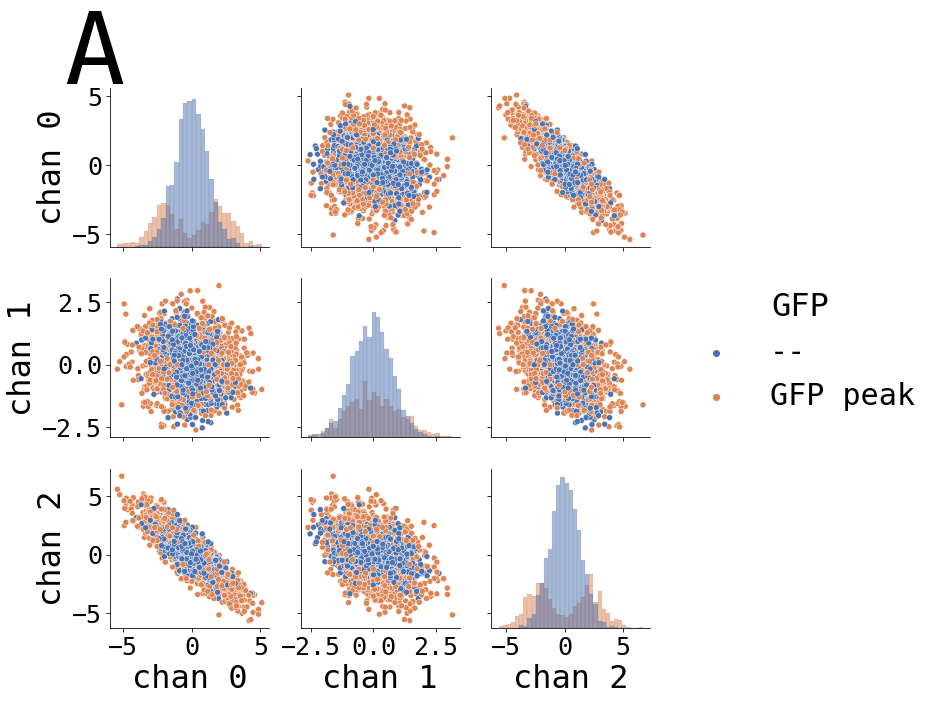

In [4]:
plot_vars = [f"chan {i}" for i in range(N_CHANNELS)]
g = sns.pairplot(
    data=data,
    vars=plot_vars,
    hue="GFP" if USE_GFP else None,
    palette="deep",
    diag_kind="hist",
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "A",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g0 = pw.load_seaborngrid(g)
g0.savefig(quick=True)

In [5]:
all_stats = pd.DataFrame()
dyn_stats = pd.DataFrame()
maps = []


def save_suff(recording, algo, gfp):
    global maps
    global all_stats
    global dyn_stats
    global data

    gfp = "GFP peaks" if gfp else "no GFP peaks"

    data[f"{algo}: {gfp}"] = recording.latent_segmentation
    maps.append(
        xr.DataArray(
            recording.latent_maps,
            dims=["latent map", "channels"],
            coords={
                "latent map": ["A", "B"],
                "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
            },
        )
        .assign_coords({"algorithm": algo, "GFP": gfp})
        .expand_dims(["algorithm", "GFP"])
    )
    recording.compute_segmentation_stats()
    df = recording.get_stats_pandas().copy()
    df["algorithm"] = algo
    df["GFP"] = gfp
    all_stats = pd.concat([all_stats, df], axis=0)

    aif1 = dynprop.lagged_mutual_information(
        recording.latent_segmentation, 2, max_lag=100, log2=True, pbar=False
    )

    dy_st = {
        "mixing time": dynprop.mixing_time(
            dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
        ),
        "entropy": dynprop.H_1(recording.latent_segmentation, 2, log2=True),
        "max entropy": dynprop.max_entropy(2, log2=True),
        "entropy rate": dynprop.excess_entropy_rate(
            recording.latent_segmentation, 2, kmax=6, log2=True
        )[0],
        "MC entropy rate": dynprop.markov_chain_entropy_rate(
            dynprop.empirical_distribution(recording.latent_segmentation, 2),
            dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
            log2=True,
        ),
        "AIF 1st peak": dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1],
        "algorithm": algo,
        "GFP": gfp,
    }
    dyn_stats = pd.concat([dyn_stats, pd.DataFrame(dy_st, index=[0])])

In [6]:
recording.run_latent_pca(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "PCA", True)

recording.run_latent_pca(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "PCA", False)


g = sns.pairplot(data=data, hue="PCA: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="PCA: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["PCA: GFP peaks"], data["PCA: no GFP peaks"], method="spearman")
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["PCA: no GFP peaks"] = data["PCA: no GFP peaks"].replace({0: 1, 1: 0})
display(accuracy_w_perm_test(data["PCA: GFP peaks"], data["PCA: no GFP peaks"]))

n         r         CI95%  p-val  power
spearman  2500  0.986912  [0.99, 0.99]    0.0    1.0

(0.9948, 0.0)

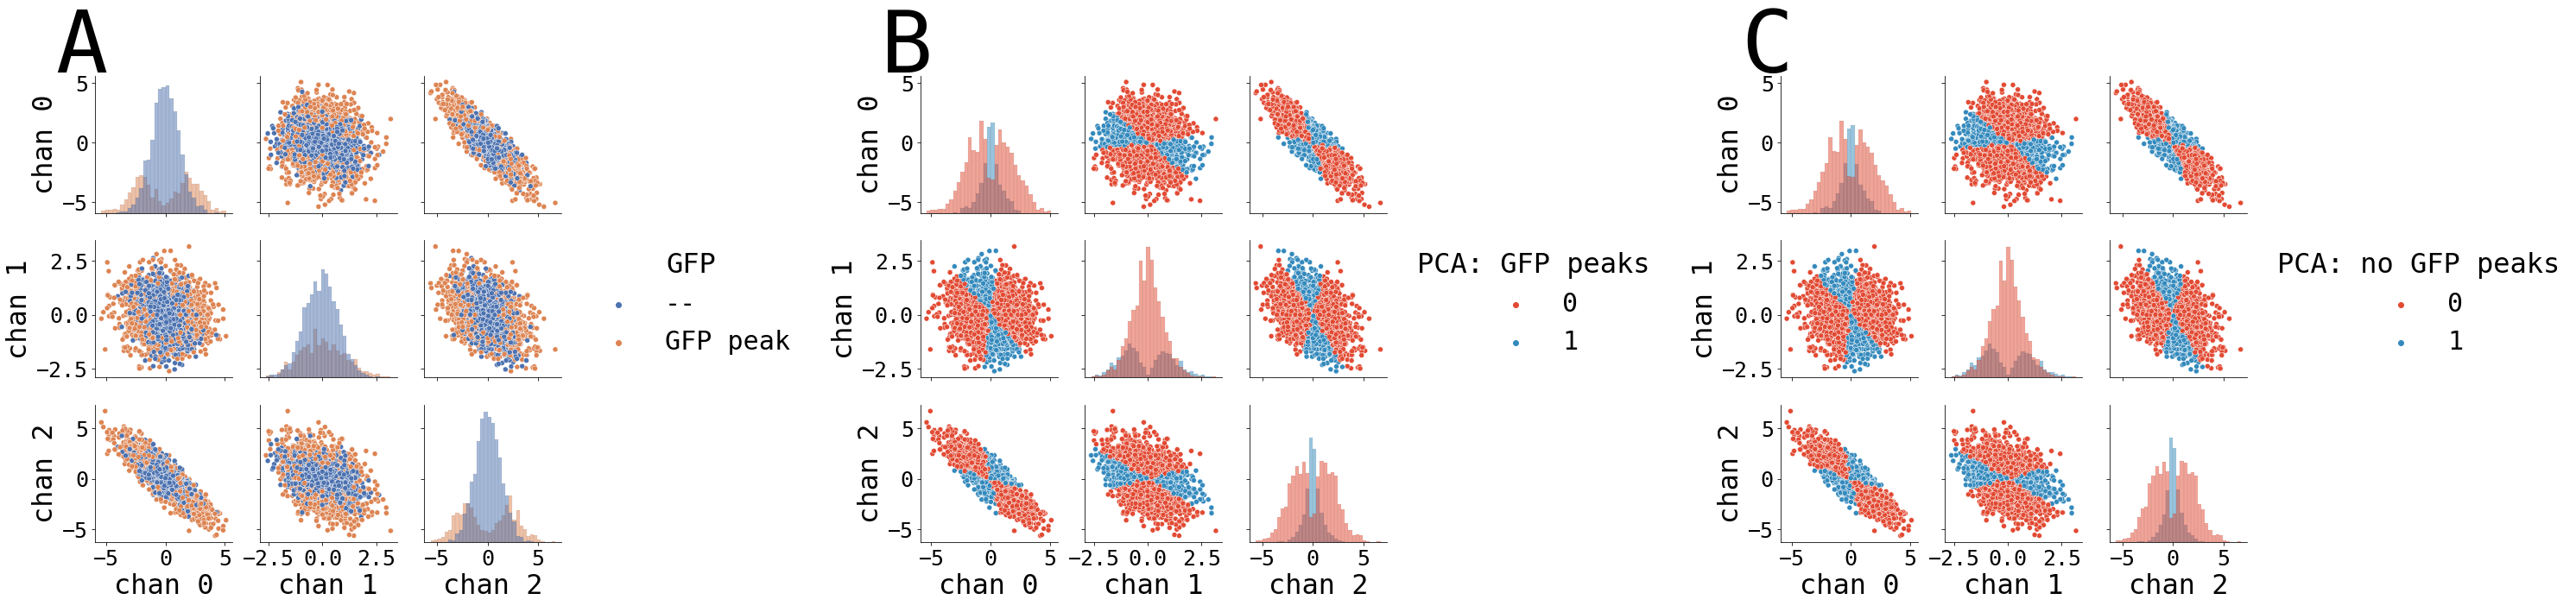

In [7]:
(g0 | g1 | g2).savefig(fname="PCA_algo.pdf", transparent=True)

In [8]:
recording.run_latent_ica(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "ICA", True)

recording.run_latent_ica(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "ICA", False)


g = sns.pairplot(data=data, hue="ICA: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="ICA: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["ICA: GFP peaks"], data["ICA: no GFP peaks"], method="spearman")
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["ICA: no GFP peaks"] = data["ICA: no GFP peaks"].replace({0: 1, 1: 0})
display(accuracy_w_perm_test(data["ICA: GFP peaks"], data["ICA: no GFP peaks"]))

n         r       CI95%  p-val  power
spearman  2500  0.996803  [1.0, 1.0]    0.0    1.0

(0.9984, 0.0)

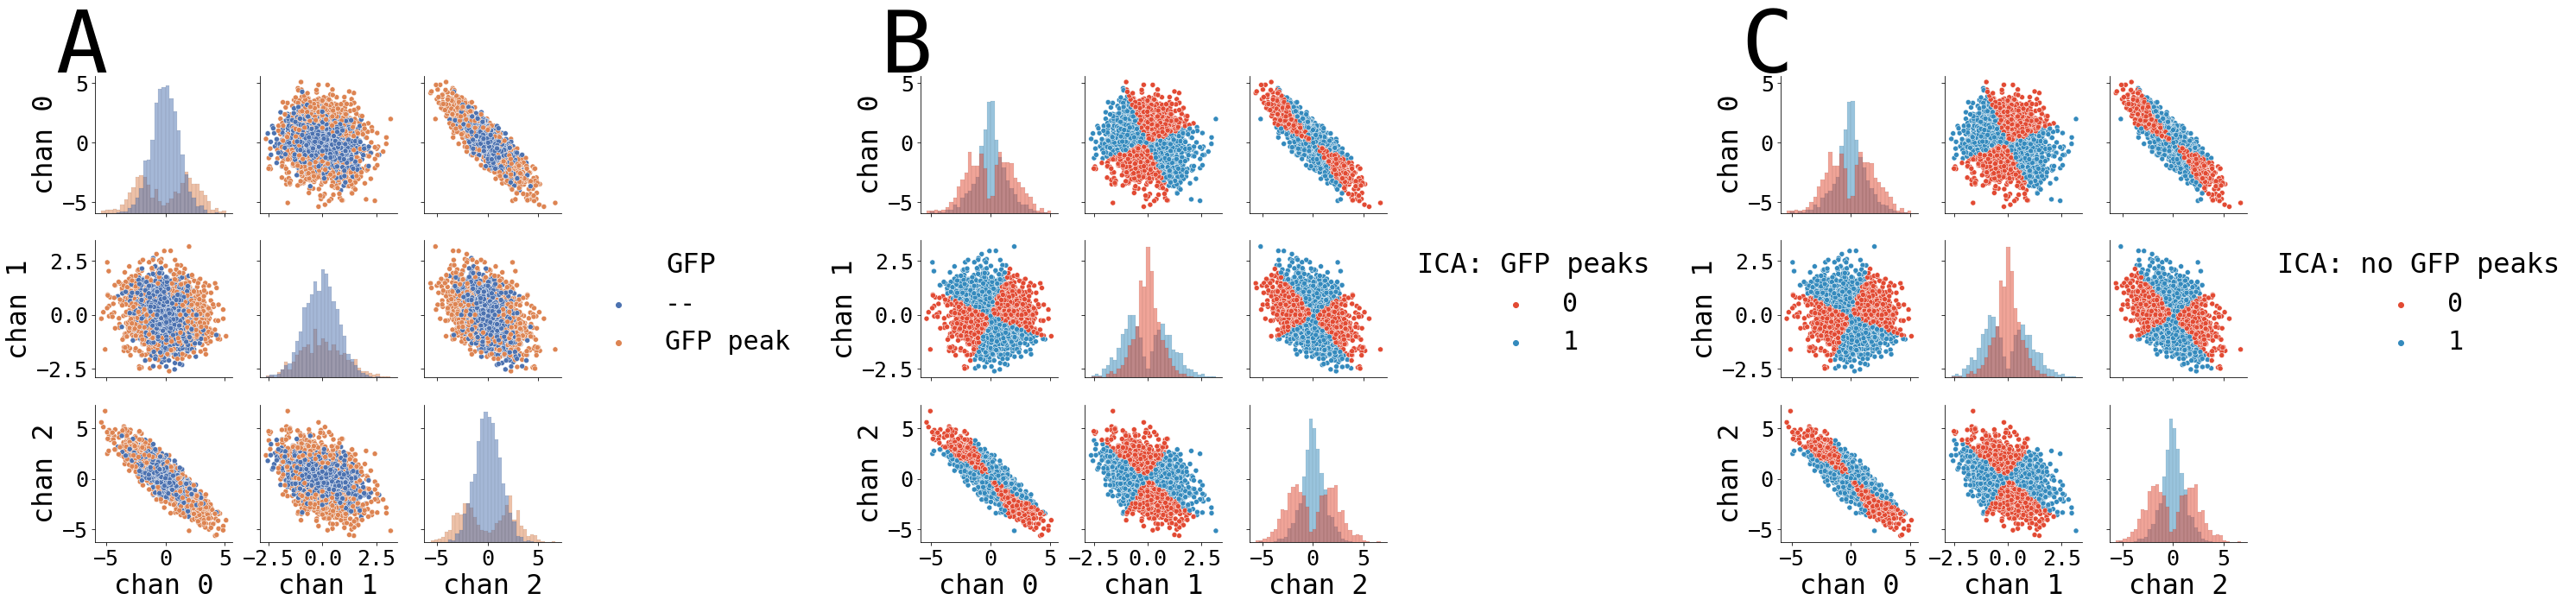

In [9]:
(g0 | g1 | g2).savefig(fname="ICA_algo.pdf", transparent=True)

In [10]:
recording.run_latent_kmeans(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "mod. K-Means", True)

recording.run_latent_kmeans(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "mod. K-Means", False)


g = sns.pairplot(
    data=data, hue="mod. K-Means: GFP peaks", vars=plot_vars, diag_kind="hist"
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(
    data=data, hue="mod. K-Means: no GFP peaks", vars=plot_vars, diag_kind="hist"
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(
    data["mod. K-Means: GFP peaks"],
    data["mod. K-Means: no GFP peaks"],
    method="spearman",
)
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["mod. K-Means: no GFP peaks"] = data["mod. K-Means: no GFP peaks"].replace(
        {0: 1, 1: 0}
    )
display(
    accuracy_w_perm_test(
        data["mod. K-Means: GFP peaks"], data["mod. K-Means: no GFP peaks"]
    )
)

n         r           CI95%  p-val  power
spearman  2500 -0.944654  [-0.95, -0.94]    0.0    1.0

(0.972, 0.0)

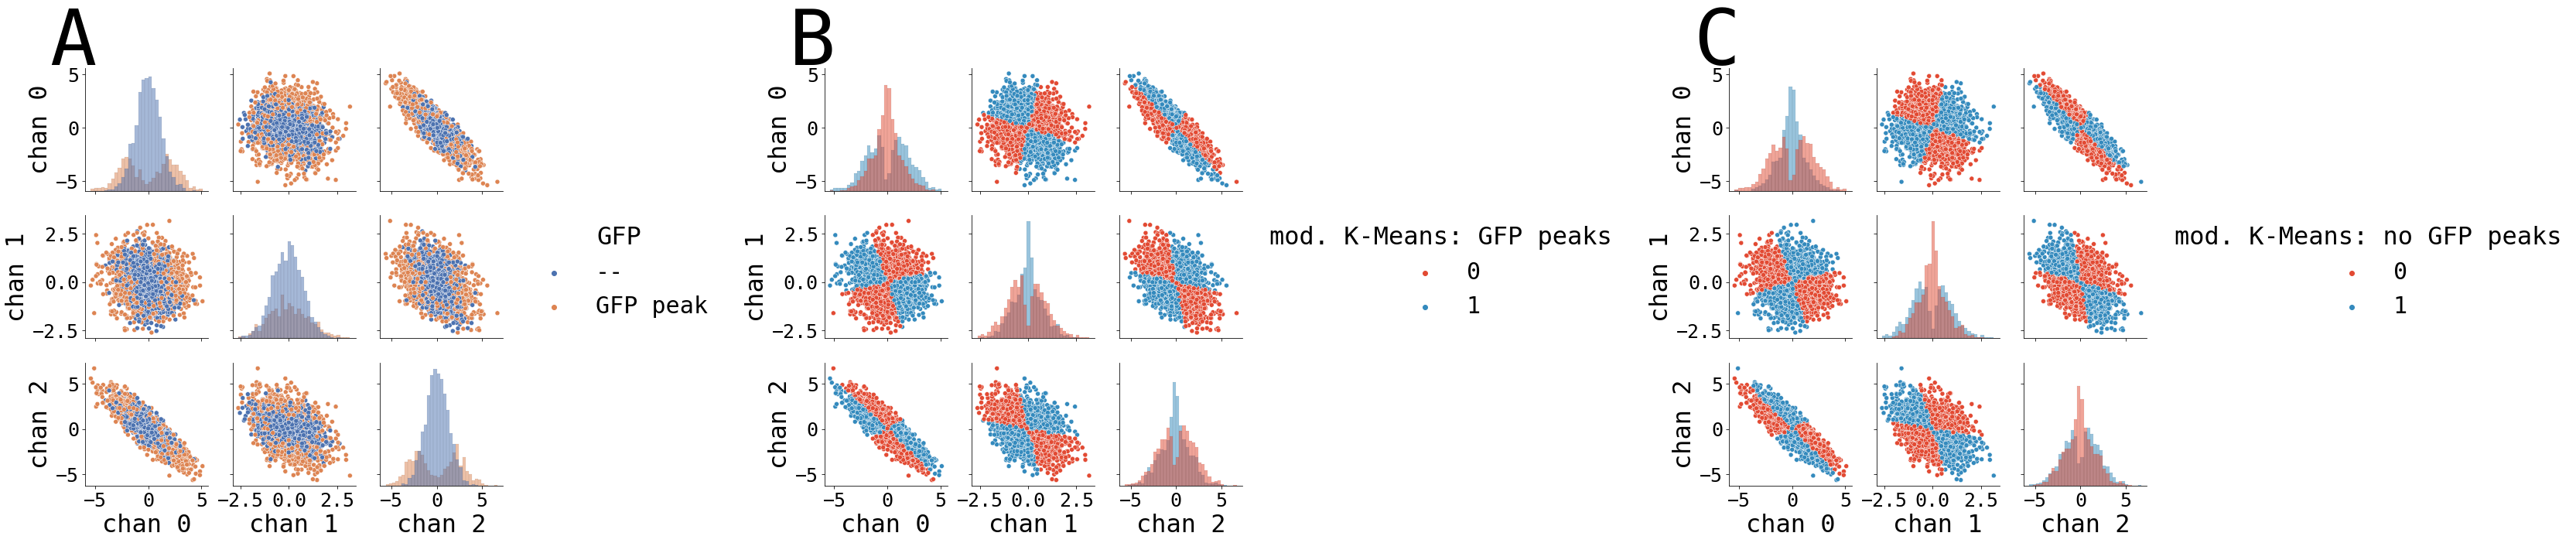

In [11]:
(g0 | g1 | g2).savefig(fname="kmeans_algo.pdf", transparent=True)

In [12]:
recording.run_latent_aahc(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "AAHC", True)

recording.run_latent_aahc(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "AAHC", False)


g = sns.pairplot(data=data, hue="AAHC: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="AAHC: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["AAHC: GFP peaks"], data["AAHC: no GFP peaks"], method="spearman")
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["AAHC: no GFP peaks"] = data["AAHC: no GFP peaks"].replace({0: 1, 1: 0})
display(accuracy_w_perm_test(data["AAHC: GFP peaks"], data["AAHC: no GFP peaks"]))

n         r        CI95%  p-val  power
spearman  2500  0.995202  [0.99, 1.0]    0.0    1.0

(0.9976, 0.0)

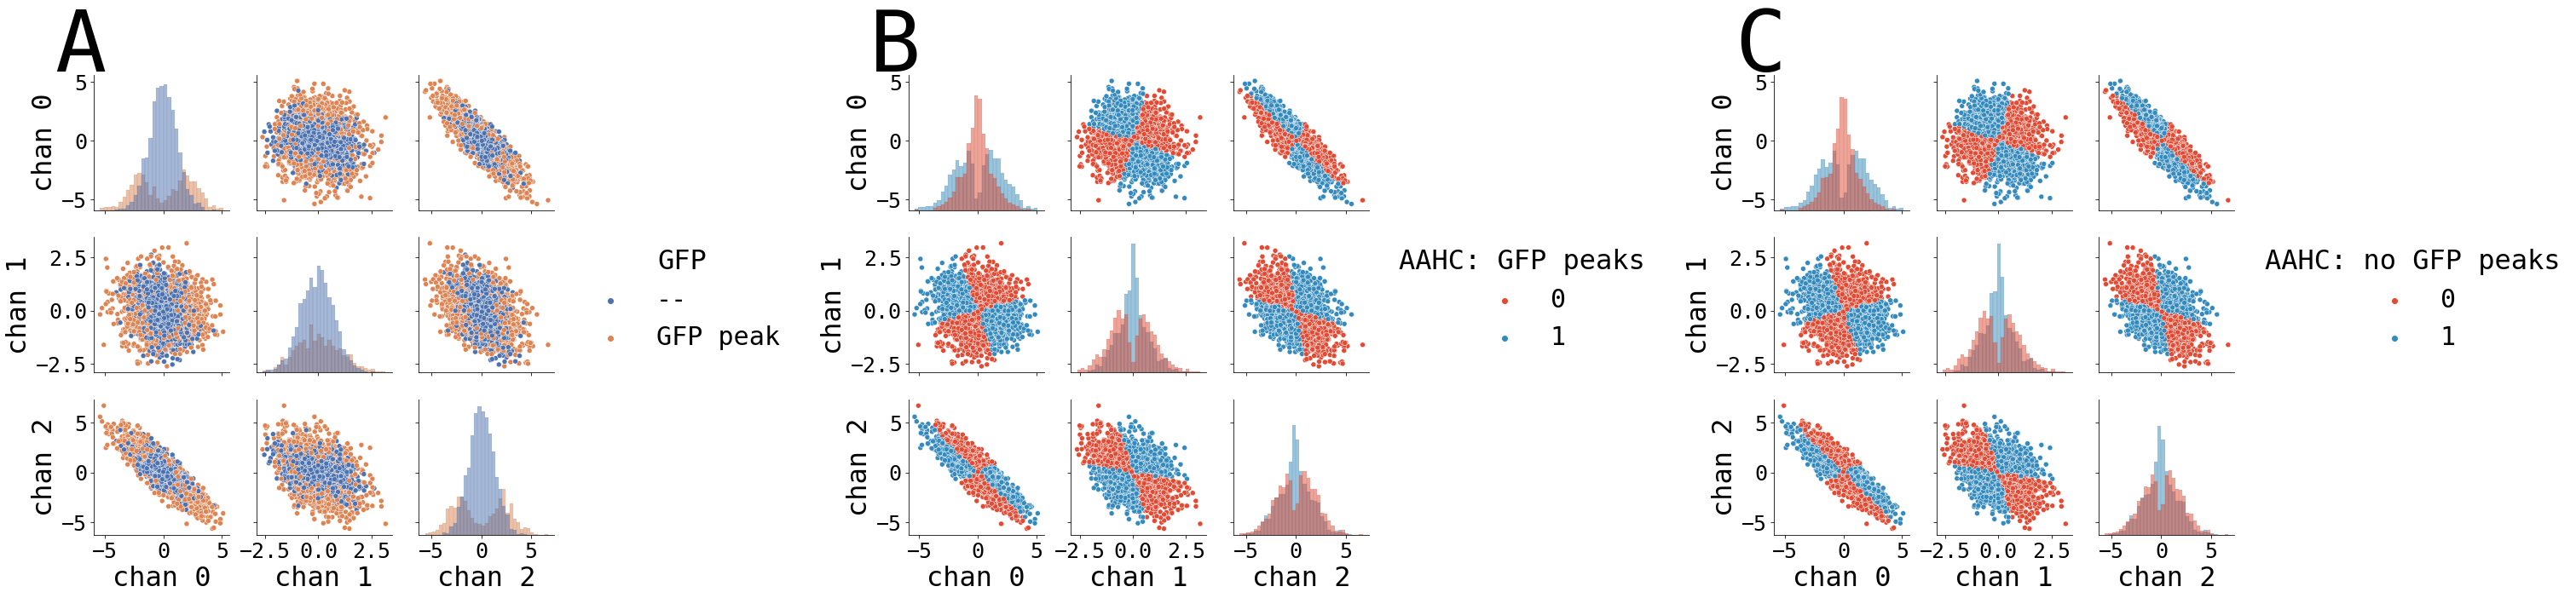

In [13]:
(g0 | g1 | g2).savefig(fname="AAHC_algo.pdf", transparent=True)

In [14]:
recording.run_latent_taahc(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "TAAHC", True)

recording.run_latent_taahc(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "TAAHC", False)

g = sns.pairplot(data=data, hue="TAAHC: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="TAAHC: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["TAAHC: GFP peaks"], data["TAAHC: no GFP peaks"], method="spearman")
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["TAAHC: no GFP peaks"] = data["TAAHC: no GFP peaks"].replace({0: 1, 1: 0})
display(accuracy_w_perm_test(data["TAAHC: GFP peaks"], data["TAAHC: no GFP peaks"]))

n         r           CI95%  p-val  power
spearman  2500 -0.992719  [-0.99, -0.99]    0.0    1.0

(0.9964, 0.0)

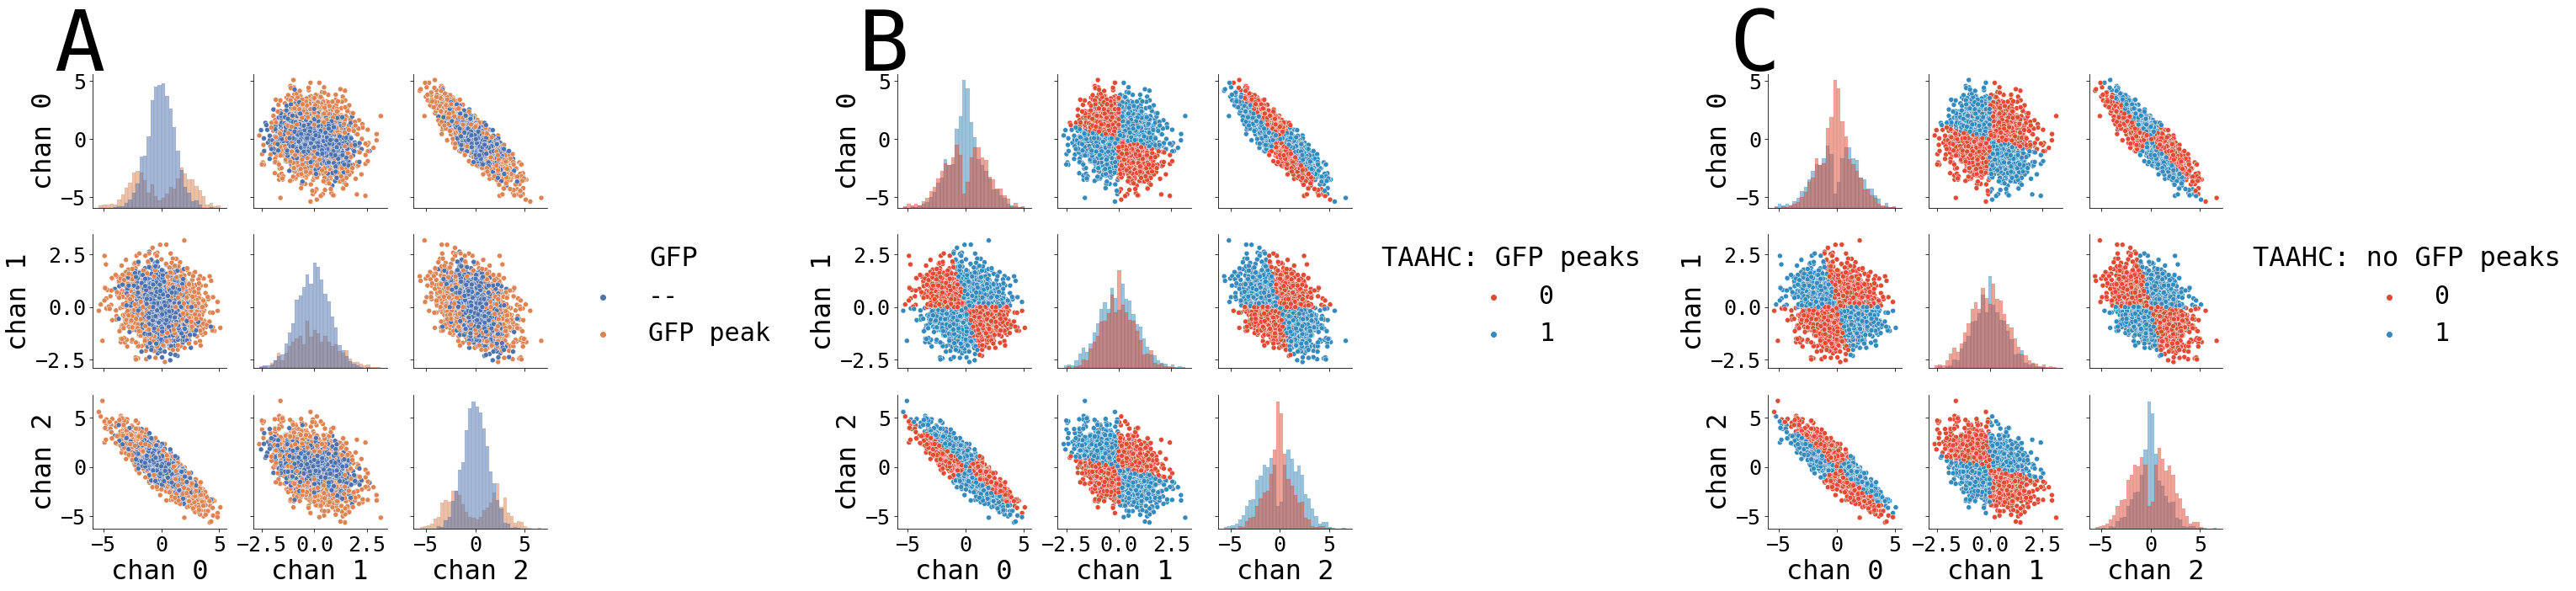

In [15]:
(g0 | g1 | g2).savefig(fname="TAAHC_algo.pdf", transparent=True)

In [16]:
recording.run_latent_hmm(N_STATES, use_gfp=True, envelope=False, pca_preprocess=None)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "HMM", True)

recording.run_latent_hmm(N_STATES, use_gfp=False, envelope=False, pca_preprocess=None)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "HMM", False)


g = sns.pairplot(data=data, hue="HMM: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="HMM: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["HMM: GFP peaks"], data["HMM: no GFP peaks"], method="spearman")
display(corr)
if corr.loc["spearman", "r"] < 0:
    data["HMM: no GFP peaks"] = data["HMM: no GFP peaks"].replace({0: 1, 1: 0})
display(accuracy_w_perm_test(data["HMM: GFP peaks"], data["HMM: no GFP peaks"]))

n         r          CI95%     p-val    power
spearman  2500  0.020821  [-0.02, 0.06]  0.298046  0.18033

(0.5204, 0.48045000000000004)

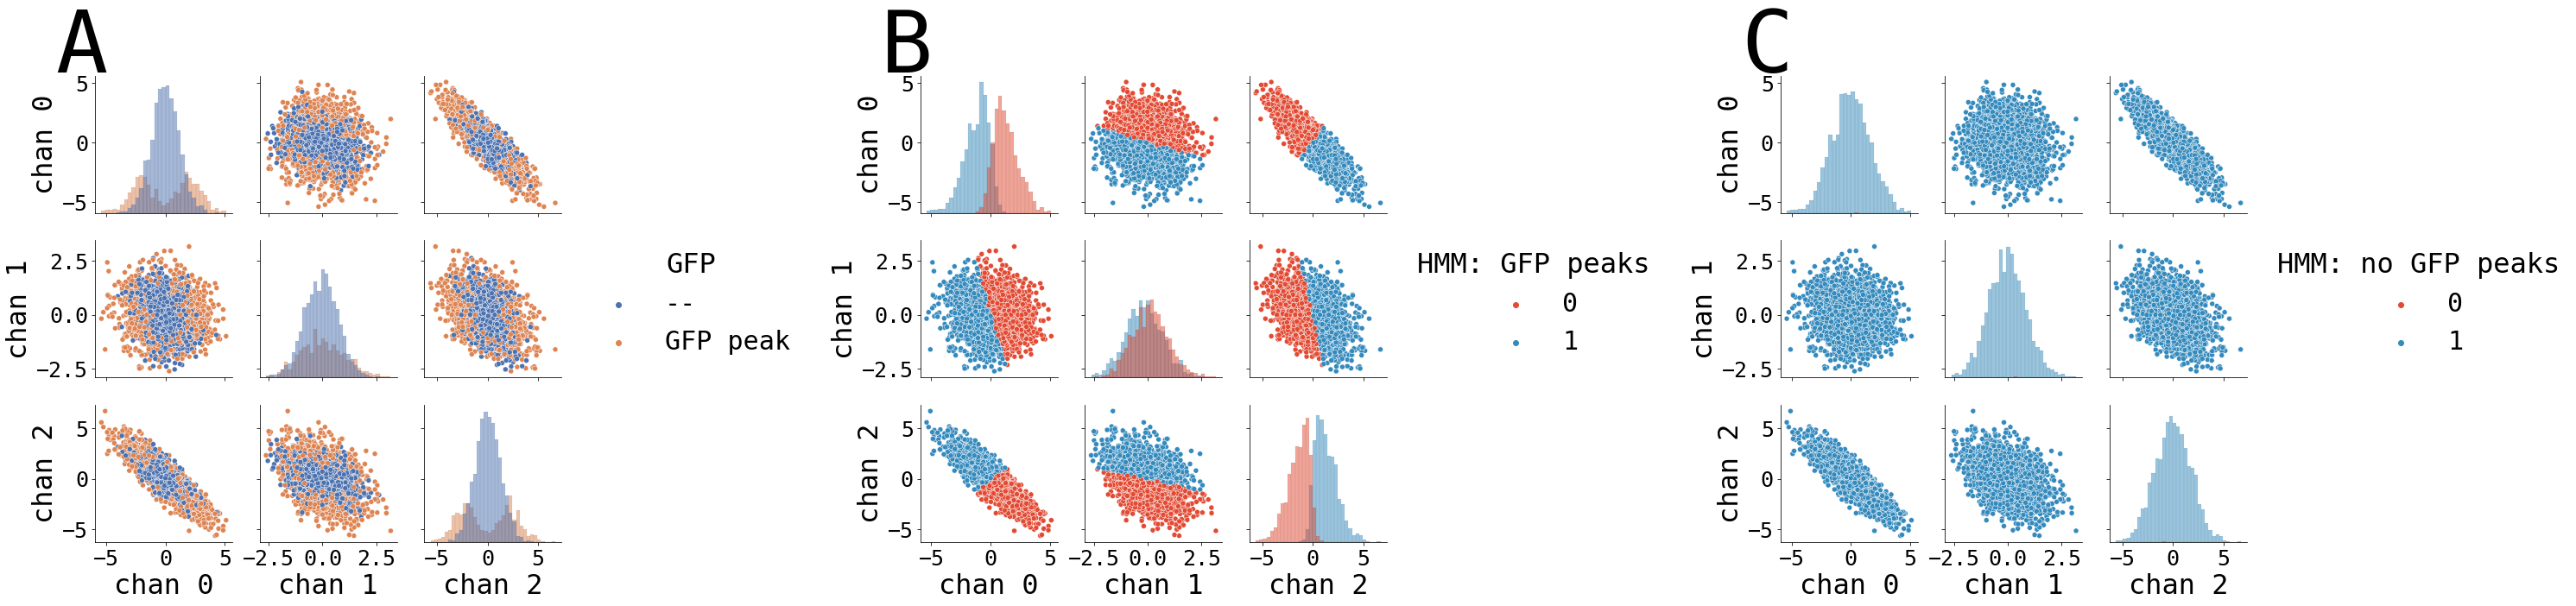

In [17]:
(g0 | g1 | g2).savefig(fname="HMM_algo.pdf", transparent=True)

In [18]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

stats_melt = (
    all_stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "latent map", "GFP"],
        value_vars=["coverage", "lifespan", "occurrence"],
    )
)

In [19]:
stats_melt

algorithm latent map           GFP    variable    value
0       AAHC          A     GFP peaks    coverage   0.4880
1       AAHC          B     GFP peaks    coverage   0.5120
2       AAHC          A  no GFP peaks    coverage   0.4864
3       AAHC          B  no GFP peaks    coverage   0.5136
4      TAAHC          A     GFP peaks    coverage   0.4436
..       ...        ...           ...         ...      ...
67       PCA          B  no GFP peaks  occurrence  48.3000
68       ICA          A     GFP peaks  occurrence  60.7000
69       ICA          B     GFP peaks  occurrence  60.7000
70       ICA          A  no GFP peaks  occurrence  60.9000
71       ICA          B  no GFP peaks  occurrence  60.9000

[72 rows x 5 columns]

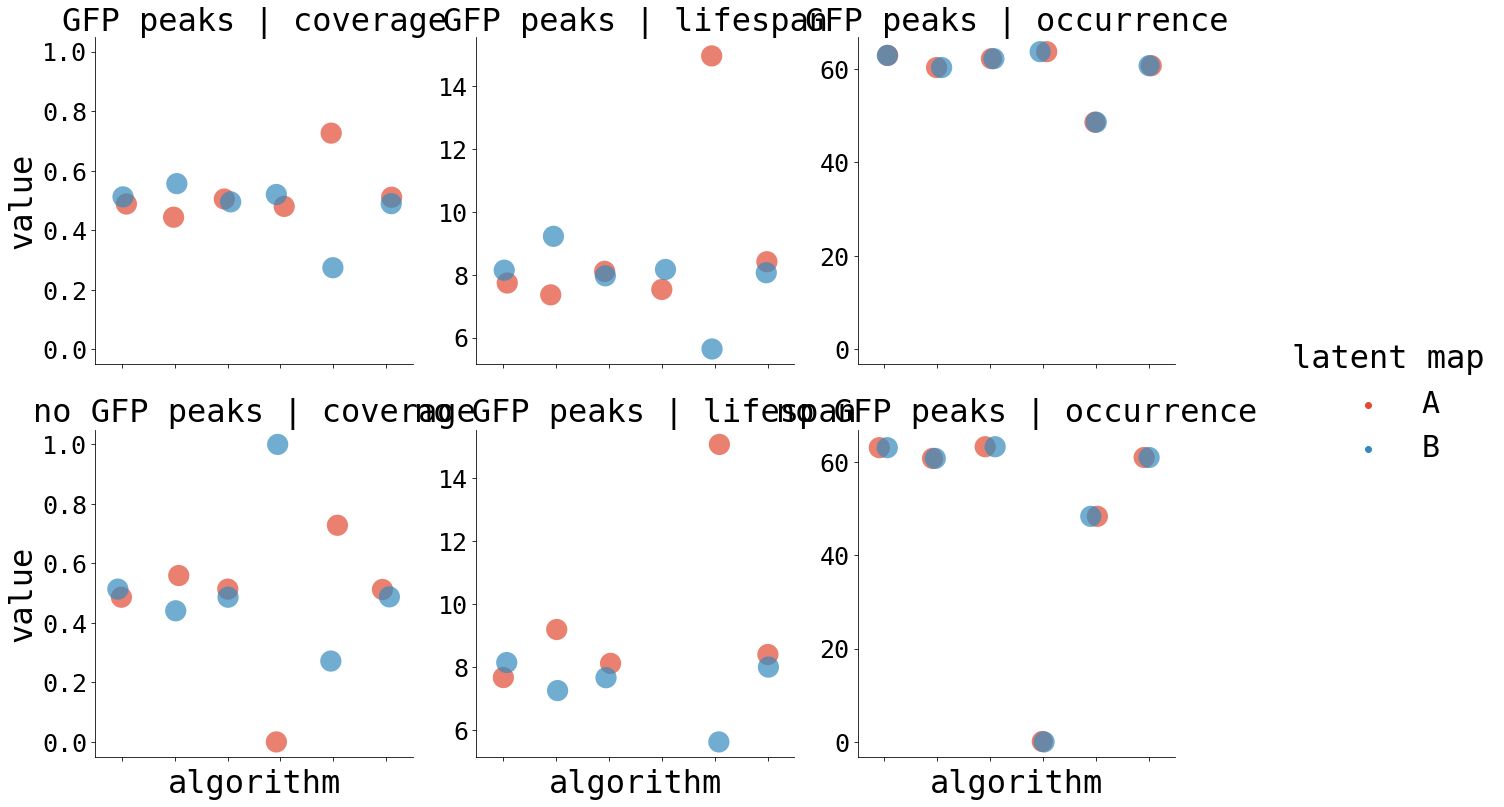

In [20]:
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    s=450,
    alpha=0.7,
    hue="latent map",
    col="variable",
    row="GFP",
    sharex=True,
    sharey="col",
    margin_titles=True,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

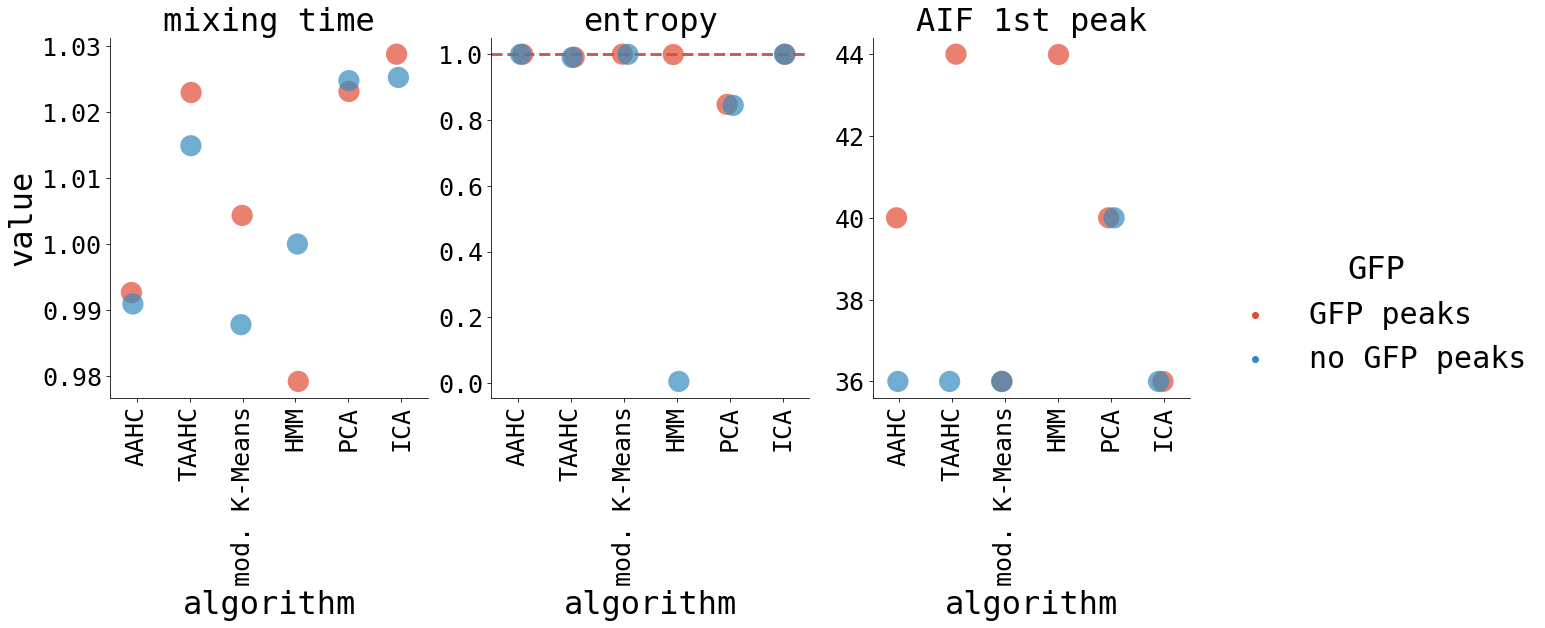

In [29]:
dyn_stats_melt = (
    dyn_stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "GFP"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dyn_stats_melt,
    x="algorithm",
    y="value",
    s=450,
    alpha=0.7,
    col="variable",
    hue="GFP",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dyn_stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g5 = pw.load_seaborngrid(g)
g5.savefig(fname="synthetic_single_stats_inf.pdf", transparent=True)

In [22]:
maps = xr.combine_by_coords(maps)
col_ord = sum(
    [[f"{alg}: GFP peaks", f"{alg}: no GFP peaks"] for alg in COLUMNS_ORDER], []
)

In [23]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                for gfp1 in maps["GFP"]:
                    for gfp2 in maps["GFP"]:
                        corrs = (
                            xr.corr(
                                maps.sel(
                                    {"algorithm": alg1, "latent map": map1, "GFP": gfp1}
                                ),
                                maps.sel(
                                    {"algorithm": alg2, "latent map": map2, "GFP": gfp2}
                                ),
                                dim="channels",
                            )
                            .assign_coords(
                                {
                                    "alg1": alg1,
                                    "alg2": alg2,
                                    "map1": map1,
                                    "map2": map2,
                                    "gfp1": gfp1,
                                    "gfp2": gfp2,
                                }
                            )
                            .expand_dims(
                                ["alg1", "alg2", "map1", "map2", "gfp1", "gfp2"]
                            )
                        )
                        all_corrs.append(corrs)
all_corrs = xr.combine_by_coords(all_corrs)

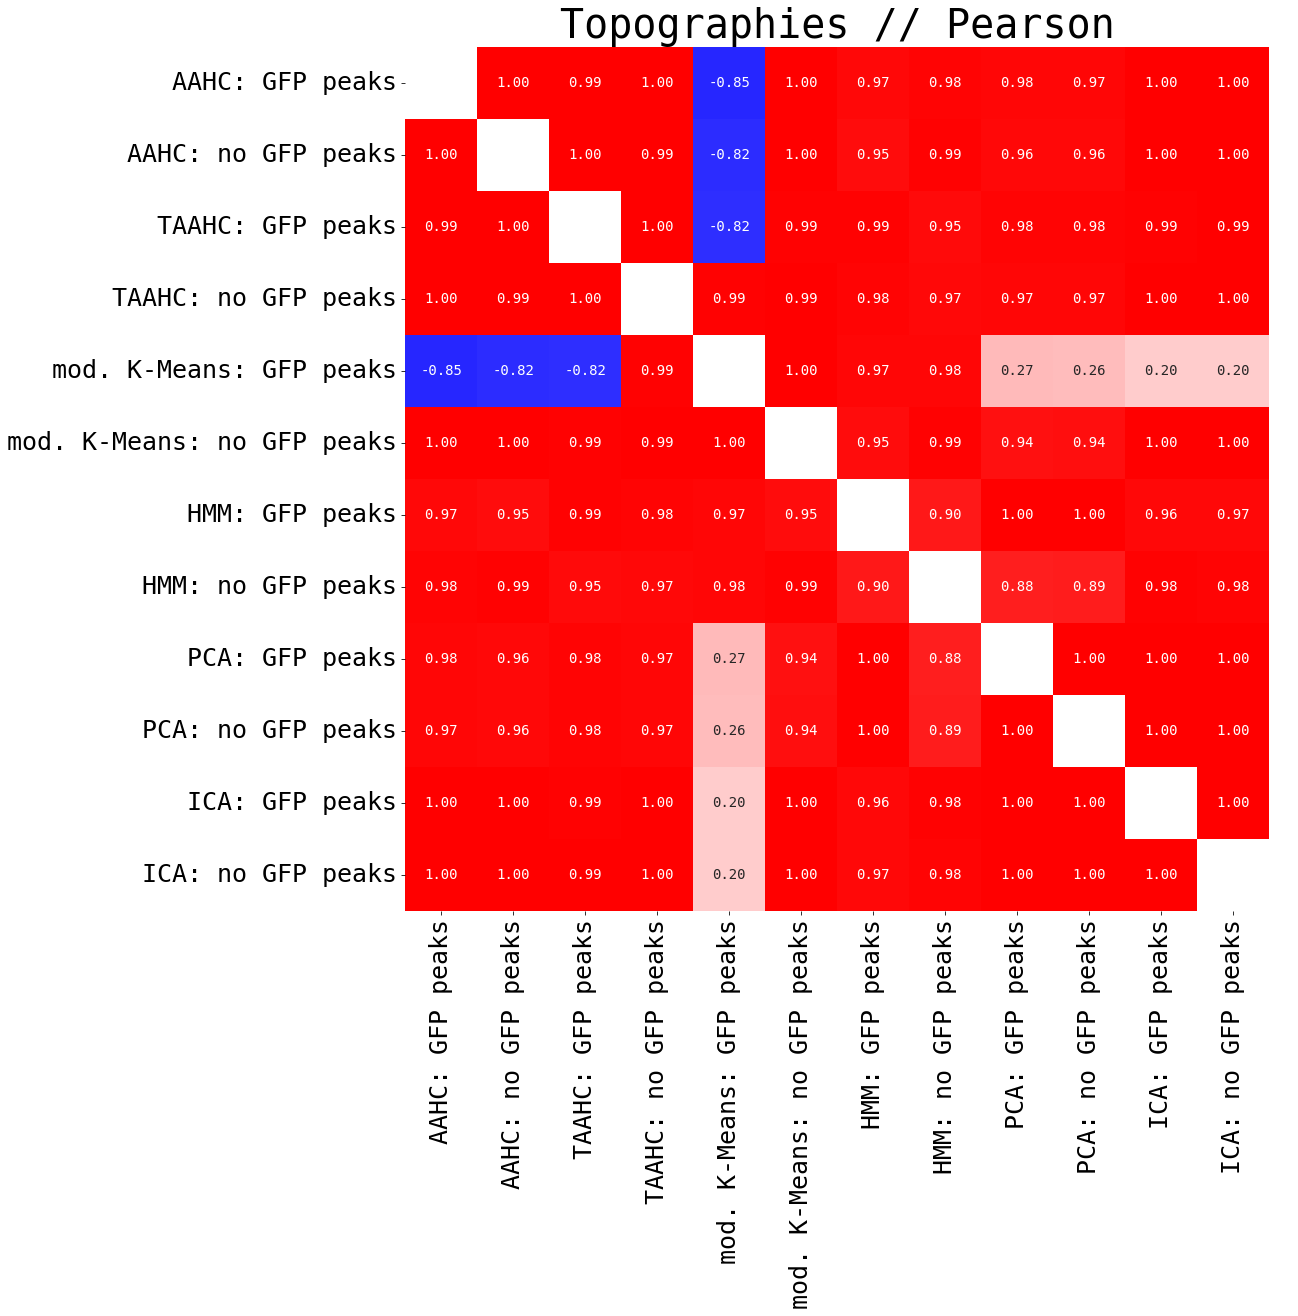

In [24]:
topo_corrs = (
    all_corrs.max(["map1", "map2"])
    .to_series()
    .reset_index()
    .pivot_table(index=["alg1", "gfp1"], columns=["alg2", "gfp2"])
)
topo_corrs.columns = topo_corrs.columns.droplevel(0)
topo_corrs.columns = [": ".join(col).strip() for col in topo_corrs.columns.values]
topo_corrs.index = [": ".join(idx).strip() for idx in topo_corrs.index.values]
topo_corrs = topo_corrs.loc[col_ord, col_ord]
np.fill_diagonal(topo_corrs.values, np.nan)

g6 = pw.Brick("ax", figsize=(12, 12))
sns.heatmap(
    topo_corrs,
    square=True,
    vmax=1.0,
    vmin=-1,
    cmap="bwr",
    annot=topo_corrs,
    fmt=".2f",
    annot_kws={"fontsize": 14},
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

In [25]:
corr_data = data[data.columns[4:]].loc[:, col_ord]
col1 = corr_data.columns[0]
for col in corr_data.columns[1:]:
    corr = pg.corr(corr_data[col1], corr_data[col], method="spearman").iloc[0, 1]
    if corr < 0:
        corr_data[col] = corr_data[col].replace({0: 1, 1: 0})


def acc(x, y):
    nans = x.isna() | y.isna()
    x = x[~nans]
    y = y[~nans]
    return accuracy_score(x, y)


accs = corr_data.apply(lambda x: corr_data.apply(lambda y: acc(x, y)))

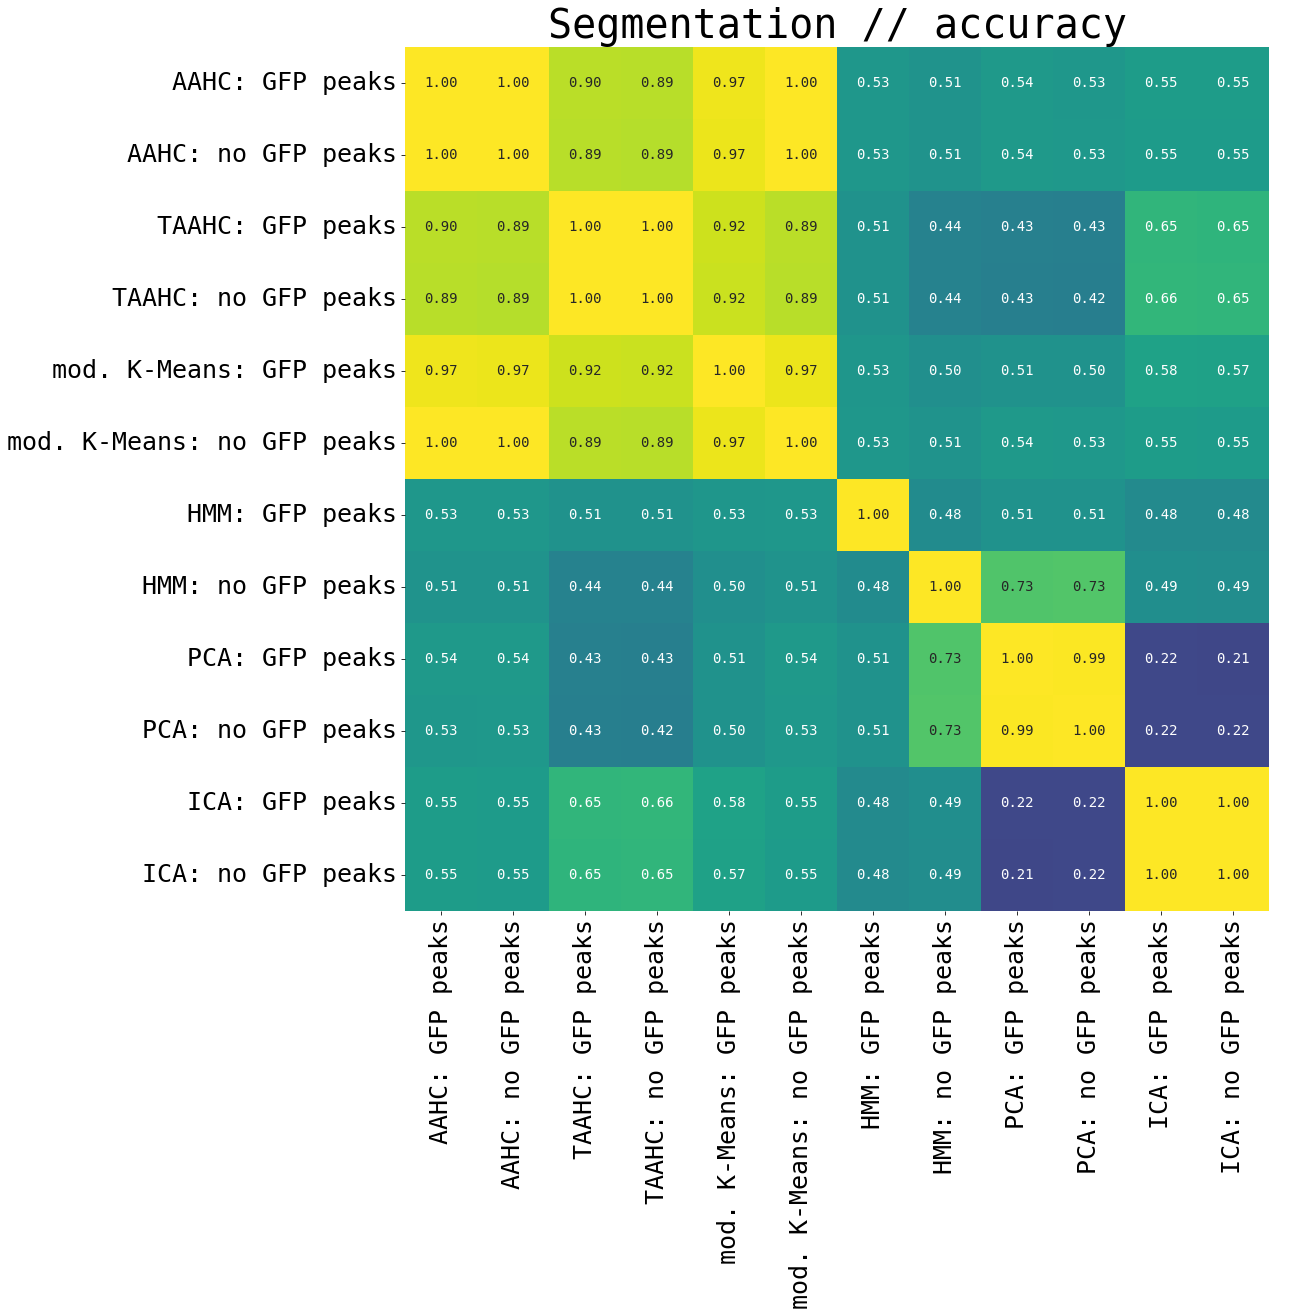

In [26]:
rcorrs = corr_data.corr("spearman")
np.fill_diagonal(rcorrs.values, np.nan)
g7 = pw.Brick("ax2", figsize=(12, 12))
sns.heatmap(
    accs,
    square=True,
    vmax=1.0,
    vmin=0,
    cmap="viridis",
    annot=accs,
    fmt=".2f",
    annot_kws={"fontsize": 14},
    ax=g7,
)
g7.set_title("Segmentation // accuracy")
g7.savefig(quick=True)

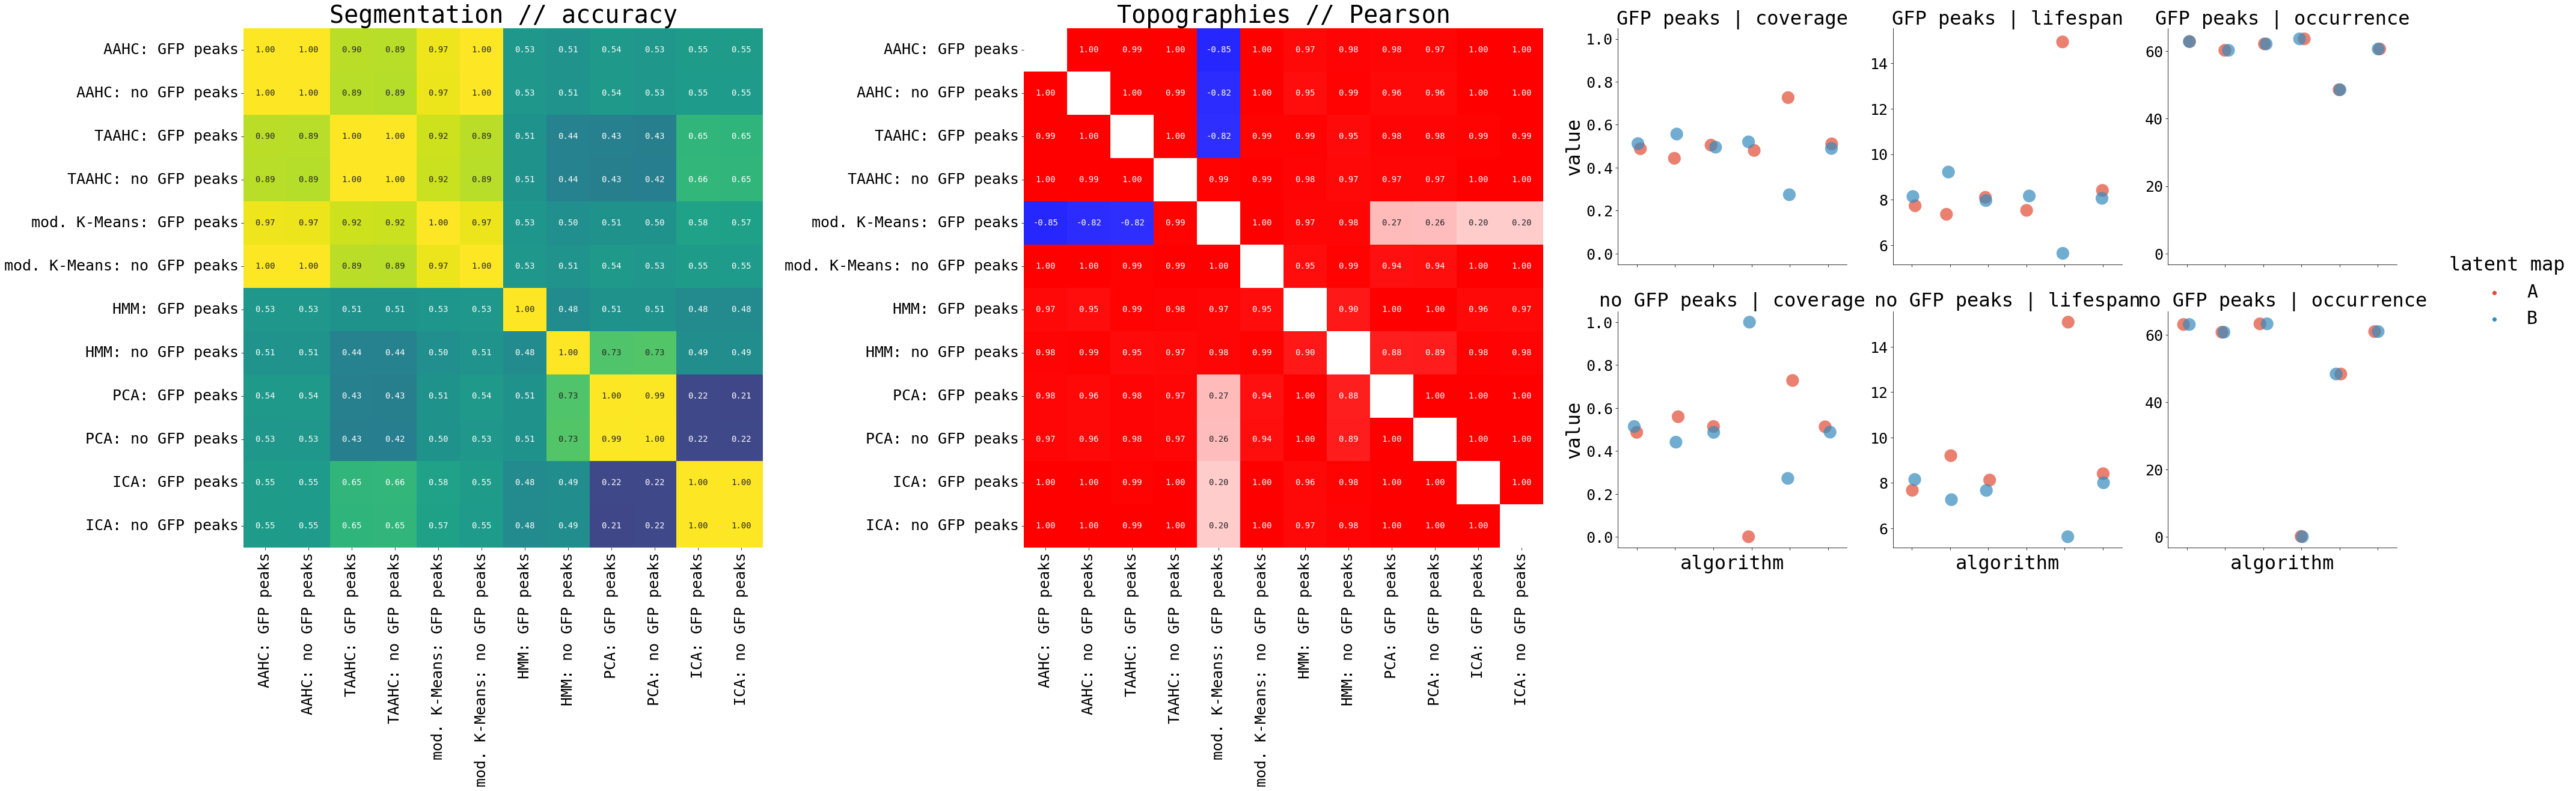

In [30]:
# ((g7 / g6) | (g4 / g5)).savefig(fname="synthetic_single_stats.pdf", transparent=True)
(g7 | g6 | g4).savefig(fname="synthetic_single_stats.pdf", transparent=True)